In [23]:
#Mount Google Drive if running in Colab

from google.colab import drive
drive.mount('/content/drive/')

filepath = '/content/drive/MyDrive/DS_Capstone/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


H5N1 Early Warning Signal Analysis
===================================
Testing Hypothesis 1: Awareness Signal Hypothesis

Do online signals (social posts, news) rise before official outbreak communications?

Approach:
1. Load and align all data sources to outbreak dates (from https://www.cdc.gov/bird-flu/situation-summary/data-map-commercial.html)
2. For each outbreak, measure signal activity in 14-day windows before/after
3. Statistical testing for significant pre-outbreak signal increases
4. Visualization of signal patterns relative to outbreaks

In [24]:
#Import libraries and set graphics styles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data sources

In [25]:
# Load USDA outbreak data
outbreaks = pd.read_csv(filepath + 'Data/commercial-backyard-flocks.csv')
outbreaks['Outbreak Date'] = pd.to_datetime(outbreaks['Outbreak Date'], errors='coerce')
outbreaks = outbreaks.dropna(subset=['Outbreak Date']).sort_values('Outbreak Date')
print(f"✓ Loaded {len(outbreaks)} outbreak records")
print(f"  Date range: {outbreaks['Outbreak Date'].min().date()} to {outbreaks['Outbreak Date'].max().date()}")

# Load X/Twitter data
twitter_file = filepath + "Data/twitter_geocoded.csv"
twitter = pd.read_csv(twitter_file, low_memory=False)
twitter['createdAt'] = pd.to_datetime(twitter['createdAt'], utc=True, errors='coerce')
twitter.dropna(subset=['createdAt'], inplace=True) # Drop rows with NaT in 'createdAt'
twitter['createdAt'] = twitter['createdAt'].dt.tz_convert(None)
twitter['date'] = twitter['createdAt'].dt.date
twitter = twitter.sort_values('createdAt')
print(f"✓ Loaded {len(twitter):,} tweets")
print(f"  Date range: {twitter['createdAt'].min()} to {twitter['createdAt'].max()}")

# ID state column in Twitter data
STATE_COL = 'loc_state'
print(f"✓ Twitter data loaded: {len(twitter)} posts")
print(f"  Posts with state info: {twitter[STATE_COL].notna().sum()}")
print(f"  Unique states: {twitter[STATE_COL].nunique()}")

# Load GDELT news data (cleaned dataset saved from GDELT tutorial nb)
gdelt = pd.read_csv(filepath + 'Data/gdelt_h5n1_cleaned.csv')
gdelt['date'] = pd.to_datetime(gdelt['date'])

✓ Loaded 1708 outbreak records
  Date range: 2022-02-08 to 2025-06-11
✓ Loaded 183,185 tweets
  Date range: 2022-06-01 01:19:03 to 2024-12-31 23:59:41
✓ Twitter data loaded: 183185 posts
  Posts with state info: 74413
  Unique states: 719


## Aggregate daily counts

In [26]:
# Twitter daily counts
print("\n2.1 Aggregating Twitter data...")
twitter['date'] = pd.to_datetime(twitter['date'])
twitter_daily = twitter.groupby('date').size().reset_index(name='twitter_count')
twitter_daily['twitter_7d_ma'] = twitter_daily['twitter_count'].rolling(7, min_periods=1).mean()
print(f"Created {len(twitter_daily)} daily records")

# GDELT daily counts
print("\n2.2 Aggregating GDELT data...")
gdelt_daily = gdelt.groupby(gdelt['date'].dt.date).size().reset_index(name='news_count')
gdelt_daily['date'] = pd.to_datetime(gdelt_daily['date'])
gdelt_daily['news_7d_ma'] = gdelt_daily['news_count'].rolling(7, min_periods=1).mean()
print(f"Created {len(gdelt_daily)} daily records")

# Outbreak daily counts
print("\n2.3 Aggregating outbreak data...")
outbreak_daily = outbreaks.groupby(outbreaks['Outbreak Date'].dt.date).agg({
    'Outbreak Date': 'size',
    'Flock Size': 'sum'
}).rename(columns={'Outbreak Date': 'outbreak_count'}).reset_index()
outbreak_daily.columns = ['date', 'outbreak_count', 'total_flock_size']
outbreak_daily['date'] = pd.to_datetime(outbreak_daily['date'])
print(f"Created {len(outbreak_daily)} daily records")


2.1 Aggregating Twitter data...
✓ Created 945 daily records

2.2 Aggregating GDELT data...
✓ Created 895 daily records

2.3 Aggregating outbreak data...
✓ Created 523 daily records


# Define analysis windows (14 days before and after outbreak)

In [27]:
# Define time windows for analysis
PRE_WINDOW = 14   # Days before outbreak to analyze
POST_WINDOW = 7   # Days after outbreak to analyze
SIGNAL_LEAD = 3   # Hypothesis: signals appear 3+ days before

# Combine Twitter and news (GDELT) signals

In [28]:
# Merge Twitter and GDELT data
signals = pd.merge(twitter_daily[['date', 'twitter_count']],
                   gdelt_daily, on='date', how='outer')
signals = signals.sort_values('date')

# Replace missing values with 0
signals['twitter_count'] = signals['twitter_count'].fillna(0)
signals['news_count'] = signals['news_count'].fillna(0)

# Normalize Twitter and news signals
# Twitter has much higher volume per day, so without normalizing, Twitter will dominate counts
signals['twitter_norm'] = (signals['twitter_count'] - signals['twitter_count'].min()) / (signals['twitter_count'].max() - signals['twitter_count'].min())
signals['news_norm'] = (signals['news_count'] - signals['news_count'].min()) / (signals['news_count'].max() - signals['news_count'].min())

# Combined signal (weighted average)
# Starting with 50/50 weighting, assuming that news and Twitter are equally important signals. May require more investigation to see if either source has a stronger or more meaningful signal.
signals['combined_signal'] = 0.5 * signals['twitter_norm'] + 0.5 * signals['news_norm']

# 7-day rolling average for smoothing
signals['combined_signal_7d'] = signals['combined_signal'].rolling(7, min_periods=1).mean()

print(f"Created combined signal index")
print(f"  Components: Twitter posts (50%) + News articles (50%)")
print(f"  Date range: {signals['date'].min().date()} to {signals['date'].max().date()}")

✓ Created combined signal index
  Components: Twitter posts (50%) + News articles (50%)
  Date range: 2022-06-01 to 2025-01-01


# Analyze signals surrounding each outbreak

In [43]:
len(pre_national)

0

In [29]:
results = []

for idx, outbreak in outbreaks.iterrows():
    outbreak_date = outbreak['Outbreak Date']

    # Define windows (14 days pre/post)
    pre_start = outbreak_date - timedelta(days=PRE_WINDOW)
    pre_end = outbreak_date - timedelta(days=1)
    post_start = outbreak_date
    post_end = outbreak_date + timedelta(days=POST_WINDOW)

    # Get signal data for windows
    pre_data = signals[(signals['date'] >= pre_start) & (signals['date'] <= pre_end)]
    post_data = signals[(signals['date'] >= post_start) & (signals['date'] <= post_end)]

    #Drop the outbreak if there isn't enough data
    if len(pre_data) == 0 or len(post_data) == 0:
        continue

    # Calculate average signal (number of posts) and max posts before
    pre_mean = pre_data['combined_signal'].mean()
    post_mean = post_data['combined_signal'].mean()
    pre_max = pre_data['combined_signal'].max()

    # Find first significant increase in pre-window
    # Define baseline as the first 50% of the pre-window
    # Baseline was selected by intuition and can be changed- just wanted a basis to compare if/when posts see a large increase
    baseline_window = len(pre_data) // 2
    if baseline_window < 2:
        baseline_window = 2 # Minimum of 2 days-mostly for outbreaks at beginning/end of date range. Outbreaks with insufficient window are dropped.

    if len(pre_data) >= baseline_window:
        baseline_data = pre_data.iloc[:baseline_window]
        baseline_mean = baseline_data['combined_signal'].mean()
        baseline_std = baseline_data['combined_signal'].std()

        # Threshold: baseline mean + 1.5 standard deviation
        # Again, 1.5 SD could be changed- just went for a metric that would indicate a large increase relative to baseline.
        threshold = baseline_mean + (1.5 * baseline_std)

        # Find first day that crosses 1.5 SD threshold as our "spike"
        detection_data = pre_data.iloc[baseline_window:]
        above_threshold = detection_data[detection_data['combined_signal'] > threshold]

        if len(above_threshold) > 0:
            detection_date = above_threshold.iloc[0]['date']
            days_before = (outbreak_date - detection_date).days
            signal_strength = above_threshold.iloc[0]['combined_signal']
        else:
            detection_date = None
            days_before = None
            signal_strength = None
    else:
        detection_date = None
        days_before = None
        signal_strength = None
        threshold = None
        baseline_mean = None

    # Statistical test: Mann-Whitney U - are pre outbreak and post outbreak counts significantly different?
    if len(pre_data) > 2 and len(post_data) > 2:
        u_stat, p_value = stats.mannwhitneyu(
            pre_data['combined_signal'].values,
            post_data['combined_signal'].values,
            alternative='greater'  # Test if pre > post
        )
    else:
        u_stat, p_value = None, None

    # Store results
    results.append({
        'outbreak_date': outbreak_date,
        'state': outbreak.get('State', 'Unknown'),
        'county': outbreak.get('County', 'Unknown'),
        'flock_type': outbreak.get('Flock Type', 'Unknown'),
        'flock_size': outbreak.get('Flock Size', 0),
        'pre_mean_signal': pre_mean,
        'post_mean_signal': post_mean,
        'signal_ratio': pre_mean / post_mean if post_mean > 0 else np.nan,
        'baseline_mean': baseline_mean,
        'threshold': threshold,
        'detection_date': detection_date,
        'days_before_outbreak': days_before,
        'signal_strength_at_detection': signal_strength,
        'meets_hypothesis': days_before >= SIGNAL_LEAD if days_before else False,
        'u_statistic': u_stat,
        'p_value': p_value,
        'significant': p_value < 0.05 if p_value else False
    })

results_df = pd.DataFrame(results)
print(f"\nAnalyzed {len(results_df)} outbreaks with sufficient data")



✓ Analyzed 1018 outbreaks with sufficient data


# Test hypothesis- can we use social media/news as early detection?

In [30]:
# Summary statistics
total_outbreaks = len(results_df)
outbreaks_with_lead = results_df['meets_hypothesis'].sum()
pct_with_lead = 100 * outbreaks_with_lead / total_outbreaks if total_outbreaks > 0 else 0

print(f"\n OVERALL RESULTS:")
print(f"  Total outbreaks analyzed: {total_outbreaks}")
print(f"  Outbreaks with {SIGNAL_LEAD}+ day lead: {outbreaks_with_lead} ({pct_with_lead:.1f}%)")
print(f"  Outbreaks with detectable signal (may have less than 3 day lead): {results_df['detection_date'].notna().sum()}")


 OVERALL RESULTS:
  Total outbreaks analyzed: 1018
  Outbreaks with 3+ day lead: 377 (37.0%)
  Outbreaks with detectable signal (may have less than 3 day lead): 476


In [31]:
# Statistics among outbreaks with 3+ day lead
valid_leads = results_df[results_df['meets_hypothesis']== True]['days_before_outbreak']
if len(valid_leads) > 0:
    print(f"\n  Signal detection lead time:")
    print(f"    Mean: {valid_leads.mean():.1f} days")
    print(f"    Median: {valid_leads.median():.1f} days")
    print(f"    Range: {valid_leads.min():.0f} to {valid_leads.max():.0f} days")
    print(f"    Detection method: First crossing of baseline + 1.5 SD")


  Signal detection lead time:
    Mean: 5.6 days
    Median: 6.0 days
    Range: 3 to 7 days
    Detection method: First crossing of baseline + 1.5 SD


In [32]:
# Statistical significance
sig_outbreaks = results_df['significant'].sum()
pct_significant = 100 * sig_outbreaks / total_outbreaks if total_outbreaks > 0 else 0
print(f"\n  Statistical significance (Mann-Whitney U):")
print(f"    Significant (p < 0.05): {sig_outbreaks} ({pct_significant:.1f}%)")

# Only a small number of outbreaks had a significantly higher number of posts pre outbreak vs post.
#This doesn't necessarily negate our hypothesis, just suggests that signals don't spike and then drop right away


  Statistical significance (Mann-Whitney U):
    Significant (p < 0.05): 58 (5.7%)


In [33]:
# Signal ratio analysis
mean_ratio = results_df['signal_ratio'].mean()
print(f"\n  Pre/Post signal ratio:")
print(f"    Mean: {mean_ratio:.2f}x")
print(f"    (>1.0 means pre-outbreak signals are higher)")


  Pre/Post signal ratio:
    Mean: 1.09x
    (>1.0 means pre-outbreak signals are higher)

HYPOTHESIS EVALUATION:
⚠ HYPOTHESIS PARTIALLY SUPPORTED
  - Some evidence of lead time (37%)
  - Further investigation needed


Only about 1/3 of outbreaks showed a spike in posts 3+ days prior to the official outbreak date on record.

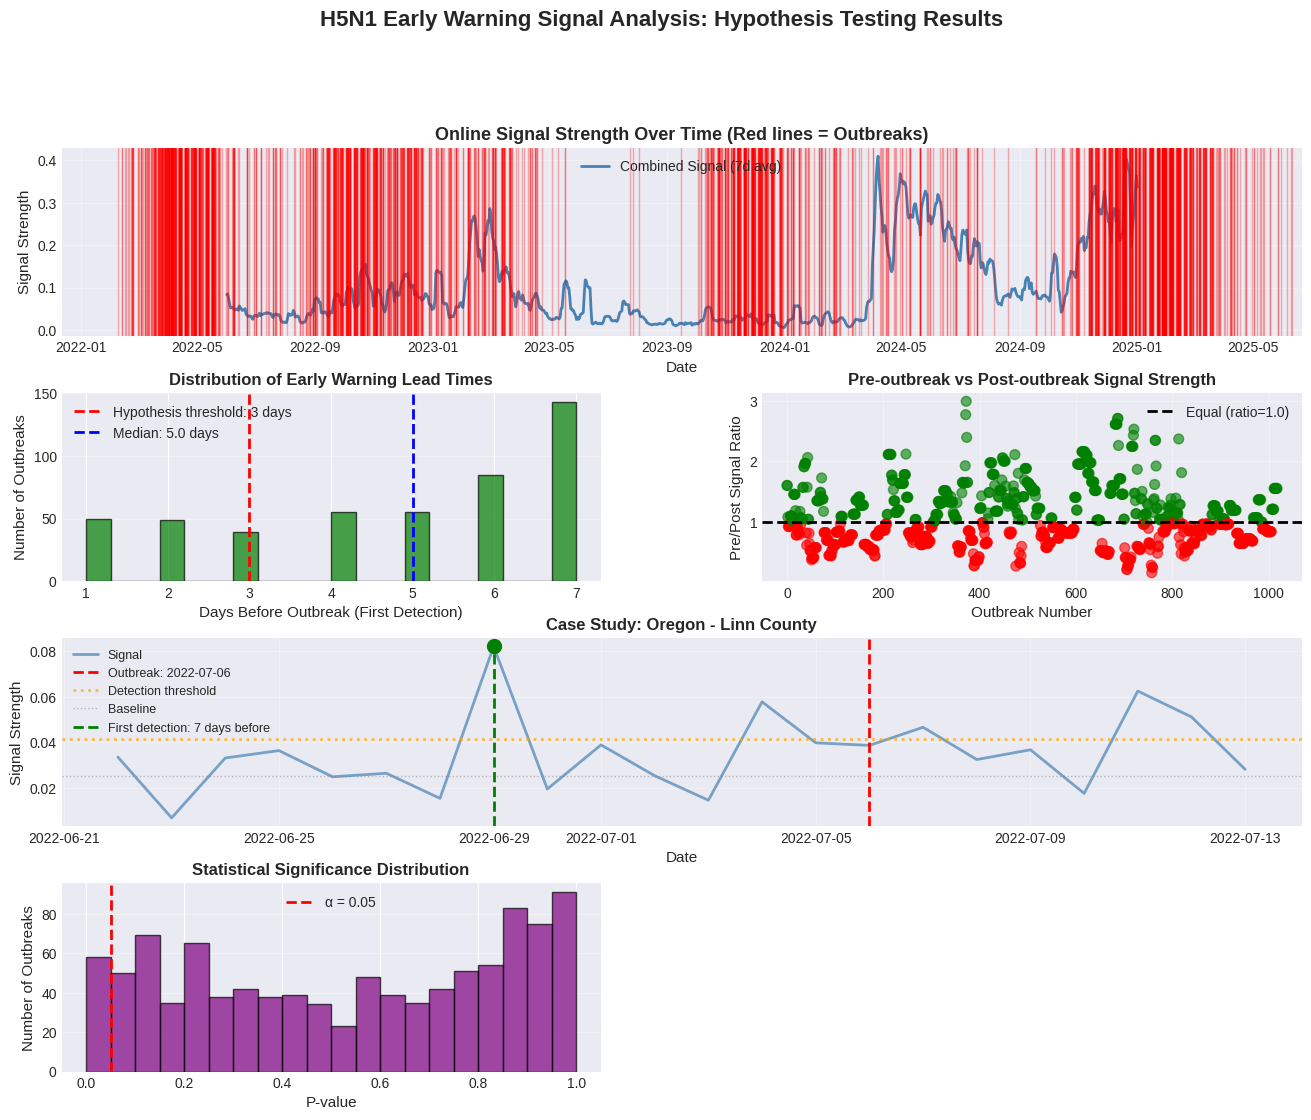

In [34]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# Plot 1: Full timeline with outbreaks marked
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(signals['date'], signals['combined_signal_7d'],
         linewidth=2, color='steelblue', label='Combined Signal (7d avg)')
for outbreak_date in outbreaks['Outbreak Date']:
    ax1.axvline(outbreak_date, color='red', alpha=0.3, linewidth=1)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Signal Strength', fontsize=11)
ax1.set_title('Online Signal Strength Over Time (Red lines = Outbreaks)',
              fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Distribution of lead times
ax2 = fig.add_subplot(gs[1, 0])
valid_leads = results_df[results_df['days_before_outbreak'].notna()]['days_before_outbreak']
ax2.hist(valid_leads, bins=20, color='green', alpha=0.7, edgecolor='black')
ax2.axvline(SIGNAL_LEAD, color='red', linestyle='--', linewidth=2,
            label=f'Hypothesis threshold: {SIGNAL_LEAD} days')
if len(valid_leads) > 0:
    ax2.axvline(valid_leads.median(), color='blue', linestyle='--', linewidth=2,
                label=f'Median: {valid_leads.median():.1f} days')
ax2.set_xlabel('Days Before Outbreak (First Detection)', fontsize=11)
ax2.set_ylabel('Number of Outbreaks', fontsize=11)
ax2.set_title('Distribution of Early Warning Lead Times', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Pre vs Post signal comparison
# Green = pre outbreak signal was higher, red = post outbreak signal was higher (not neccessarily significantly different)
ax3 = fig.add_subplot(gs[1, 1])
valid_ratios = results_df[results_df['signal_ratio'].notna()]
colors = ['green' if x >= 1.0 else 'red' for x in valid_ratios['signal_ratio']]
ax3.scatter(range(len(valid_ratios)), valid_ratios['signal_ratio'],
            c=colors, alpha=0.6, s=50)
ax3.axhline(1.0, color='black', linestyle='--', linewidth=2, label='Equal (ratio=1.0)')
ax3.set_xlabel('Outbreak Number', fontsize=11)
ax3.set_ylabel('Pre/Post Signal Ratio', fontsize=11)
ax3.set_title('Pre-outbreak vs Post-outbreak Signal Strength',
              fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Example case study - pick outbreak with good lead time
ax4 = fig.add_subplot(gs[2, :])
if len(results_df[results_df['meets_hypothesis']]) > 0:
    example = results_df[results_df['meets_hypothesis']].iloc[0]
    outbreak_date = example['outbreak_date']
    window_start = outbreak_date - timedelta(days=PRE_WINDOW)
    window_end = outbreak_date + timedelta(days=POST_WINDOW)

    window_data = signals[(signals['date'] >= window_start) &
                          (signals['date'] <= window_end)]

    ax4.plot(window_data['date'], window_data['combined_signal'],
             linewidth=2, color='steelblue', label='Signal', alpha=0.7)
    ax4.axvline(outbreak_date, color='red', linewidth=2, linestyle='--',
                label=f'Outbreak: {outbreak_date.date()}')

    # Show baseline threshold
    if pd.notna(example['threshold']):
        ax4.axhline(example['threshold'], color='orange', linewidth=2,
                    linestyle=':', label=f"Detection threshold", alpha=0.7)
        ax4.axhline(example['baseline_mean'], color='gray', linewidth=1,
                    linestyle=':', label=f"Baseline", alpha=0.5)

    # Mark detection point
    if pd.notna(example['detection_date']):
        ax4.axvline(example['detection_date'], color='green', linewidth=2,
                    linestyle='--', label=f"First detection: {example['days_before_outbreak']:.0f} days before")
        ax4.scatter([example['detection_date']], [example['signal_strength_at_detection']],
                   color='green', s=100, zorder=5, marker='o')

    ax4.set_xlabel('Date', fontsize=11)
    ax4.set_ylabel('Signal Strength', fontsize=11)
    ax4.set_title(f"Case Study: {example['state']} - {example['county']} County",
                  fontsize=12, fontweight='bold')
    ax4.legend(loc='upper left', fontsize=9)
    ax4.grid(True, alpha=0.3)

# Plot 5: P-value distribution
ax5 = fig.add_subplot(gs[3, 0])
valid_pvals = results_df[results_df['p_value'].notna()]['p_value']
ax5.hist(valid_pvals, bins=20, color='purple', alpha=0.7, edgecolor='black')
ax5.axvline(0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
ax5.set_xlabel('P-value', fontsize=11)
ax5.set_ylabel('Number of Outbreaks', fontsize=11)
ax5.set_title('Statistical Significance Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('H5N1 Early Warning Signal Analysis: Hypothesis Testing Results',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

Evidence that signals spike before an outbreak is announced is weak- only about 45% of cases showed pre-outbreak signal spikes, and only a third met the 3+ day threshold. This might not be any more than picking up on random noise.

So far, we've been looking at signals- both social media and news media- on a global level, which may introduce more noise- chatter about H5N1 happening online in Europe probably isn't a good signal of an outbreak in the rural US. Let's add a state-specific focus by
1. Limiting to just Twitter data, which includes state data in many cases (GDELT is limited to country-level)
2. Doing the same analysis but only looking at posts originating in the state where the outbreak occurs

Limitations:
- Location information on Twitter is user-input and may be inaccurate, missing, or invalid (unable to be geocoded)
- This may reduce the number of valid posts available for this analysis, and we are not guaranteed to have posts from each state where there was an outbreak.
- State-level is still not very specific, but using an even more local lens further limits the valid Twitter posts available.

## Aggregate state-specific daily counts

In [ ]:
# Twitter by state and date
twitter_state_daily = (
    twitter[twitter[STATE_COL].notna()]
    .groupby([pd.Grouper(key='date', freq='D'), STATE_COL])
    .size()
    .reset_index(name='twitter_count')
)

## Look at outbreaks with signals by state
Use same metrics as global analysis.

In [47]:
results_state = []
results_global = []

for idx, outbreak in outbreaks.iterrows():
    outbreak_date = outbreak['Outbreak Date']
    outbreak_state = outbreak['State']

    pre_start = outbreak_date - timedelta(days=PRE_WINDOW)
    pre_end = outbreak_date - timedelta(days=1)
    post_start = outbreak_date
    post_end = outbreak_date + timedelta(days=POST_WINDOW)

    # ========== STATE-SPECIFIC ANALYSIS ==========
    # Get Twitter data for this state only
    state_data = twitter_state_daily[twitter_state_daily[STATE_COL] == outbreak_state].copy()

    pre_state = state_data[(state_data['date'] >= pre_start) & (state_data['date'] <= pre_end)]
    post_state = state_data[(state_data['date'] >= post_start) & (state_data['date'] <= post_end)]

    #Drop the outbreak if there isn't enough data
    if len(pre_state) == 0 or len(post_state) == 0:
        continue

    if len(pre_state) >= 4:  # Minimum 4 days for analysis
        # Normalize state signal
        if pre_state['twitter_count'].max() > pre_state['twitter_count'].min():
            pre_state['signal'] = (pre_state['twitter_count'] - pre_state['twitter_count'].min()) / \
                                  (pre_state['twitter_count'].max() - pre_state['twitter_count'].min())
        else:
            pre_state['signal'] = 0.5

        # Baseline detection
        baseline_window = len(pre_state) // 2
        if baseline_window >= 2:
            baseline_data = pre_state.iloc[:baseline_window]
            baseline_mean = baseline_data['signal'].mean()
            baseline_std = baseline_data['signal'].std()
            threshold = baseline_mean + (1.5 * baseline_std)

            detection_data = pre_state.iloc[baseline_window:]
            above_threshold = detection_data[detection_data['signal'] > threshold]

            if len(above_threshold) > 0:
                detection_date = above_threshold.iloc[0]['date']
                days_before = (outbreak_date - detection_date).days
            else:
                detection_date = None
                days_before = None
        else:
            detection_date = None
            days_before = None
            threshold = None
            baseline_mean = None

        # Statistical test
        if len(pre_state) > 2 and len(post_state) > 2:
            u_stat, p_value = stats.mannwhitneyu(
                pre_state['twitter_count'].values,
                post_state['twitter_count'].values,
                alternative='greater'
            )
        else:
            u_stat, p_value = None, None

        results_state.append({
            'outbreak_date': outbreak_date,
            'state': outbreak_state,
            'signal_type': 'state_specific',
            'days_before_outbreak': days_before,
            'meets_hypothesis': days_before >= SIGNAL_LEAD if days_before else False,
            'p_value': p_value,
            'significant': p_value < 0.05 if p_value else False,
            'pre_days': len(pre_state),
            'baseline_mean': baseline_mean,
            'threshold': threshold
        })

    # ========== GLOBAL COMPARISON ==========
    # Use same logic but with global data
    pre_global = twitter_daily[(twitter_daily['date'] >= pre_start) &
                                          (twitter_daily['date'] <= pre_end)]
    post_global = twitter_daily[(twitter_daily['date'] >= post_start) &
                                           (twitter_daily['date'] <= post_end)]

    #Drop the outbreak if there isn't enough data
    if len(pre_global) == 0 or len(post_global) == 0:
        continue

    if len(pre_global) >= 4:
        if pre_global['twitter_count'].max() > pre_global['twitter_count'].min():
            pre_global['signal'] = (pre_global['twitter_count'] - pre_global['twitter_count'].min()) / \
                                     (pre_global['twitter_count'].max() - pre_global['twitter_count'].min())
        else:
            pre_global['signal'] = 0.5

        baseline_window = len(pre_global) // 2
        if baseline_window >= 2:
            baseline_data = pre_global.iloc[:baseline_window]
            baseline_mean = baseline_data['signal'].mean()
            baseline_std = baseline_data['signal'].std()
            threshold = baseline_mean + (1.5 * baseline_std)

            detection_data = pre_global.iloc[baseline_window:]
            above_threshold = detection_data[detection_data['signal'] > threshold]

            if len(above_threshold) > 0:
                detection_date = above_threshold.iloc[0]['date']
                days_before = (outbreak_date - detection_date).days
            else:
                days_before = None
        else:
            days_before = None

        results_global.append({
            'outbreak_date': outbreak_date,
            'state': outbreak_state,
            'signal_type': 'national',
            'days_before_outbreak': days_before,
            'meets_hypothesis': days_before >= SIGNAL_LEAD if days_before else False
        })

results_state_df = pd.DataFrame(results_state)
results_global_df = pd.DataFrame(results_global)

print(f"Analyzed {len(results_state_df)} outbreaks with state data")
print(f"Analyzed {len(results_global_df)} outbreaks with global data")

Analyzed 378 outbreaks with state data
Analyzed 542 outbreaks with global data


## Compare state and global performance

In [48]:
# State-specific results
state_detectable = results_state_df['days_before_outbreak'].notna().sum()
state_meets = results_state_df['meets_hypothesis'].sum()
state_pct = 100 * state_meets / len(results_state_df) if len(results_state_df) > 0 else 0

# Global results
global_detectable = results_global_df['days_before_outbreak'].notna().sum()
global_meets = results_global_df['meets_hypothesis'].sum()
global_pct = 100 * global_meets / len(results_global_df) if len(results_global_df) > 0 else 0

print(f"\n  STATE-SPECIFIC SIGNALS:")
print(f"  Total outbreaks: {len(results_state_df)}")
print(f"  Detectable signals: {state_detectable} ({100*state_detectable/len(results_state_df):.1f}%)")
print(f"  Meets 3+ day threshold: {state_meets} ({state_pct:.1f}%)")

if results_state_df['days_before_outbreak'].notna().sum() > 0:
    valid_leads = results_state_df[results_state_df['days_before_outbreak'].notna()]['days_before_outbreak']
    print(f"  Mean lead time: {valid_leads.mean():.1f} days")
    print(f"  Median lead time: {valid_leads.median():.1f} days")

print(f"\n GLOBAL SIGNALS:")
print(f"  Total outbreaks: {len(results_global_df)}")
print(f"  Detectable signals: {global_detectable} ({100*global_detectable/len(results_global_df):.1f}%)")
print(f"  Meets 3+ day threshold: {global_meets} ({global_pct:.1f}%)")

if results_global_df['days_before_outbreak'].notna().sum() > 0:
    valid_leads = results_global_df[results_global_df['days_before_outbreak'].notna()]['days_before_outbreak']
    print(f"  Mean lead time: {valid_leads.mean():.1f} days")
    print(f"  Median lead time: {valid_leads.median():.1f} days")

print(f"\n IMPROVEMENT:")
improvement = state_pct - global_pct
print(f"  State signals vs global: {improvement:+.1f} percentage points")
if improvement > 0:
    print(f"  State-specific signals perform BETTER")
elif improvement < 0:
    print(f"  State-specific signals perform WORSE")
else:
    print(f"  = No difference")



  STATE-SPECIFIC SIGNALS:
  Total outbreaks: 378
  Detectable signals: 169 (44.7%)
  Meets 3+ day threshold: 137 (36.2%)
  Mean lead time: 4.6 days
  Median lead time: 5.0 days

 GLOBAL SIGNALS:
  Total outbreaks: 542
  Detectable signals: 282 (52.0%)
  Meets 3+ day threshold: 235 (43.4%)
  Mean lead time: 5.1 days
  Median lead time: 6.0 days

 IMPROVEMENT:
  State signals vs global: -7.1 percentage points
  State-specific signals perform WORSE


Looking at state-specific posts performs worse than gloabl data, although this might be partly due to limited data from Twitter (just not enough signals to find the pattern). Let's see if there's a difference when comparing states to each other.

In [49]:
state_summary = results_state_df.groupby('state').agg({
    'outbreak_date': 'count',
    'meets_hypothesis': 'sum',
    'days_before_outbreak': lambda x: x.notna().sum()
}).rename(columns={
    'outbreak_date': 'total_outbreaks',
    'meets_hypothesis': 'early_detections',
    'days_before_outbreak': 'detectable_signals'
})

state_summary['detection_rate'] = 100 * state_summary['early_detections'] / state_summary['total_outbreaks']
state_summary = state_summary.sort_values('detection_rate', ascending=False)

print("\nTop 10 states by early detection rate:")
print(state_summary.head(10).to_string())


Top 10 states by early detection rate:
                total_outbreaks  early_detections  detectable_signals  detection_rate
state                                                                                
Arizona                       2                 2                   2      100.000000
South Carolina                2                 2                   2      100.000000
Vermont                       1                 1                   1      100.000000
Massachusetts                 2                 2                   2      100.000000
Illinois                      4                 3                   3       75.000000
Colorado                     10                 7                   7       70.000000
Washington                    8                 5                   5       62.500000
Utah                          7                 4                   5       57.142857
Wyoming                       2                 1                   1       50.000000
Nebraska      

With the small Ns, it's hard to tell if this is real or just random.

## Visualizations

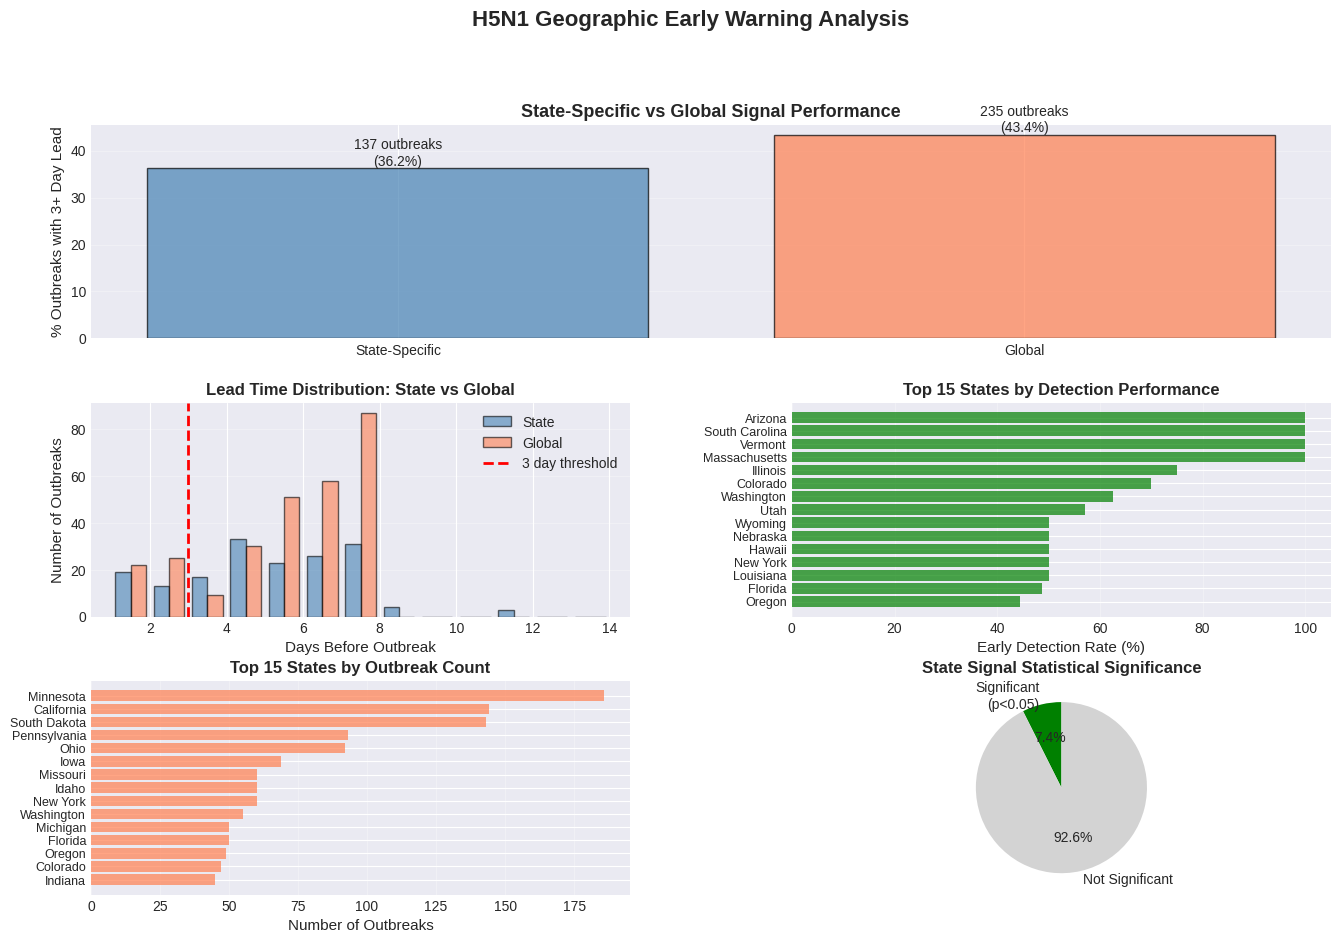

In [50]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: State vs global comparison
ax1 = fig.add_subplot(gs[0, :])
comparison = pd.DataFrame({
    'Signal Type': ['State-Specific', 'Global'],
    'Detection Rate': [state_pct, global_pct],
    'Count': [state_meets, global_meets]
})
bars = ax1.bar(comparison['Signal Type'], comparison['Detection Rate'],
               color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('% Outbreaks with 3+ Day Lead', fontsize=11)
ax1.set_title('State-Specific vs Global Signal Performance', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for i, (bar, count) in enumerate(zip(bars, comparison['Count'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count} outbreaks\n({height:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# Plot 2: Lead time distribution comparison
ax2 = fig.add_subplot(gs[1, 0])
state_leads = results_state_df[results_state_df['days_before_outbreak'].notna()]['days_before_outbreak']
global_leads = results_global_df[results_global_df['days_before_outbreak'].notna()]['days_before_outbreak']
ax2.hist([state_leads, global_leads], bins=range(1, 15), alpha=0.6,
         label=['State', 'Global'], color=['steelblue', 'coral'], edgecolor='black')
ax2.axvline(SIGNAL_LEAD, color='red', linestyle='--', linewidth=2, label=f'{SIGNAL_LEAD} day threshold')
ax2.set_xlabel('Days Before Outbreak', fontsize=11)
ax2.set_ylabel('Number of Outbreaks', fontsize=11)
ax2.set_title('Lead Time Distribution: State vs Global', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: State performance map
ax3 = fig.add_subplot(gs[1, 1])
top_states = state_summary.head(15)
ax3.barh(range(len(top_states)), top_states['detection_rate'], color='green', alpha=0.7)
ax3.set_yticks(range(len(top_states)))
ax3.set_yticklabels(top_states.index, fontsize=9)
ax3.set_xlabel('Early Detection Rate (%)', fontsize=11)
ax3.set_title('Top 15 States by Detection Performance', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

# Plot 4: Outbreak volume by state
ax4 = fig.add_subplot(gs[2, 0])
outbreak_counts = outbreaks['State'].value_counts().head(15)
ax4.barh(range(len(outbreak_counts)), outbreak_counts.values, color='coral', alpha=0.7)
ax4.set_yticks(range(len(outbreak_counts)))
ax4.set_yticklabels(outbreak_counts.index, fontsize=9)
ax4.set_xlabel('Number of Outbreaks', fontsize=11)
ax4.set_title('Top 15 States by Outbreak Count', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.invert_yaxis()

# Plot 5: Statistical significance
ax5 = fig.add_subplot(gs[2, 1])
state_sig = results_state_df['significant'].sum()
state_total = len(results_state_df)
sig_data = pd.DataFrame({
    'Category': ['Significant\n(p<0.05)', 'Not Significant'],
    'Count': [state_sig, state_total - state_sig]
})
colors_pie = ['green', 'lightgray']
ax5.pie(sig_data['Count'], labels=sig_data['Category'], autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
ax5.set_title('State Signal Statistical Significance', fontsize=12, fontweight='bold')

plt.suptitle('H5N1 Geographic Early Warning Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('h5n1_geographic_analysis.png', dpi=300, bbox_inches='tight')

The state analysis still isn't very promising- the states with high rates of outbreaks don't tend to be the ones with good signal detection from Twitter alone. Additional signal sources may prove helpful to get a more representative sample of social media use (i.e. if more people use Facebook than Twitter)